# Whole dataset

In [1]:
from sklearn import linear_model
import csv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.linear_model import lasso_path
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

## Data pre-processing 

Load the data set and seperate the dataset into predictors and targets. the first column of targets is the EUI need to be predicted, the third column is the sample weighting.

In [2]:
data = np.genfromtxt('ALL_ATRIB_DATA.csv',delimiter=',',skip_header=1)

In [3]:
Predictor = data[:,0:159]

In [4]:
Target = data[:, 159:162]

The missing values to be imputed before fit the model

Separate numeric values to other values as they are imputed differently

In [5]:
all_predictor = list(range(159))
numeric_index =  [0, 18, 20, 38, 40, 45, 47, 58, 70, 79, 103, 104, 106, 110, 113, 136, 138, 147, 156, 157, 158]
bi_no_index = [item for item in all_predictor if item not in numeric_index]
print(len(numeric_index))
print(len(bi_no_index))
len(numeric_index) + len(bi_no_index) == len(all_predictor)

21
138


True

In [6]:
# Binary and categorical values are imputed as most frequendt
imp_bi = Imputer(missing_values='NaN', strategy='most_frequent', axis = 0)
imp_bi.fit(Predictor[:,bi_no_index])
Predictor[:,bi_no_index] = imp_bi.transform(Predictor[:,bi_no_index])

In [7]:
#Numeric values are imputed as median (to elimanates influence of extreme values)
imp_num = Imputer(missing_values='NaN', strategy='median', axis = 0)
imp_num.fit(Predictor[:,numeric_index])
Predictor[:,numeric_index] = imp_num.transform(Predictor[:,numeric_index])

In [8]:
imp_tar = Imputer(missing_values = 'NaN', strategy = 'median', axis = 0)
imp_tar.fit(Target)
Target = imp_tar.transform(Target)

## Exploratory analysis 

Plot the Total EUI distribution to give an indication of consumption condition

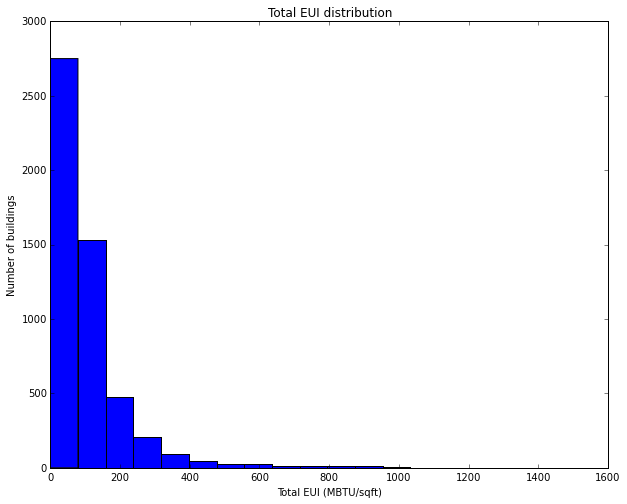

In [9]:
plt.figure(figsize=(10, 8))
plt.hist(Target[:,0], bins = 20)
plt.ylabel("Number of buildings")
plt.xlabel("Total EUI (MBTU/sqft)")
plt.title("Total EUI distribution")

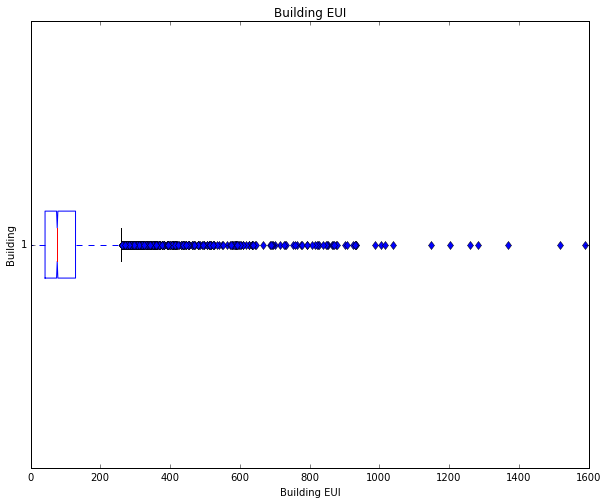

In [10]:
plt.figure(figsize=(10, 8))
plt.boxplot(Target[:,0], notch=True, sym='bd', vert=False)
plt.xlabel("Building EUI")
plt.ylabel("Building")
plt.title("Building EUI")

## Model establishement 

Seperating data into training and testing set

In [11]:
trainPredictor = Predictor[0:len(Predictor)//2]
testPredictor = Predictor[len(Predictor)//2: len(Predictor)]
trainTarget = Target[0:len(Target)//2]
testTarget = Target[len(Target)//2:len(Target)]
print(len(trainPredictor) + len(testPredictor) == len(Predictor))
print(len(trainTarget) + len(testTarget) == len(Target))
print(len(trainPredictor) == len(trainTarget))
print(len(testPredictor) == len(testTarget))
print(trainPredictor.shape)
print(trainTarget.shape)

True
True
True
True
(2607L, 159L)
(2607L, 3L)


A series functions are defined to fit and evaluate the model

In [12]:
#This function gives back the Lasso regression coefficient after the model is fitted
def lasso_fit(alpha, predictor, Target):
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(predictor,Target)
    coefficient = clf.coef_
    return coefficient

In [13]:
# the function returns the predicted y matrix of test dataset
def lasso_results(alpha_input, train_X, train_y, test_X, test_y):
    clf = linear_model.Lasso(alpha=alpha_input)
    clf.fit(train_X,train_y)
    # a column of ones is added to the design matrix to fit the intercept
    oneMatrix = np.ones((len(test_X),1))
    DesignMatrix = np.concatenate((test_X, oneMatrix),axis = 1)
    coefficients = np.concatenate((clf.coef_ , [clf.intercept_]), axis = 0)
    testResults = np.dot(DesignMatrix, coefficients)
    return testResults

In [14]:
# the function returns the evaluator of the lasso fit (r_square, mse)
def lasso_test(alpha_input, train_X, train_y, test_X, test_y, testWeight):
    r_square = []
    mse = []
    for a in alpha_input:
        testResults = lasso_results(a, train_X, train_y, test_X, test_y)
        r_square.append(r2_score(test_y, testResults, sample_weight = testWeight))
        mse.append(mean_squared_error(test_y, testResults, sample_weight =testWeight))
    index = mse.index(min(mse))
    evaluator = np.stack((r_square, mse), axis = 1)
    return {"evaluator": evaluator, "r_square": r_square[index], "MSE": mse[index], "alpha":alpha_input[index]}

In [15]:
#find best fit using LassoCV
def lasso_cros(alpha_input, train_X, train_Y, test_X, test_Y):
    clf2 = LassoCV(alphas = alpha_range, cv = 5)
    clf2.fit(train_X, train_Y)
    plt.figure(figsize=(15,10)) 
    plt.plot(np.log10(clf2.alphas_), clf2.mse_path_[:], '--')
    plt.plot(np.log10(clf2.alphas_), clf2.mse_path_.mean(axis=-1), 'k-')
    plt.show()
    return {'alpha':clf2.alpha_, 'r_square':clf2.score(train_X, train_Y), 'intercept':clf2.intercept_, 'Minimum MSE': min(clf2.mse_path_.mean(axis=-1))}

In [16]:
#this function give the number of features selected under each alpha
def num_feature(alpha_input, train_X, train_y):
    num_feature = []
    for alpha_input in alpha_input:
        clf = linear_model.Lasso(alpha=alpha_input)
        clf.fit(train_X,train_y)
        num = find_features(clf.coef_)["count"]
        num_feature.append(num)
    return num_feature

In [17]:
#This function give the features selected (non-zero coefficient)
def find_features(coeff):
    index = []
    count = 0
    for i in range(len(coeff)):
        if coeff[i] != 0:
            index.append(i)
            count += 1
    return {'index':index, 'count': count}

The optimum model is first analyzed using self-defined method

In [27]:
#define alpha range
alpha_range = np.logspace(-2, 2, num = 1000, base = 10)

In [30]:
#extract MSE and number of features selected from given alpha range
evaluators = lasso_test(alpha_range, trainPredictor, trainTarget[:,0], testPredictor, testTarget[:,0], testTarget[:,2])["evaluator"]

In [20]:
#and number of features selected from given alpha range
num_feature = num_feature(alpha_range, trainPredictor, trainTarget[:,0])

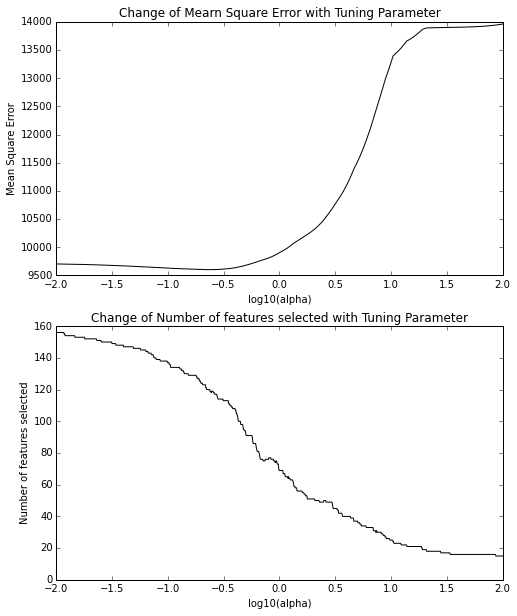

In [31]:
#Plot the results
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(np.log10(np.logspace(-2, 2, num = 1000, base =10)), evaluators[:,1], 'k-')
plt.ylabel("Mean Square Error")
plt.xlabel("log10(alpha)")
plt.title("Change of Mearn Square Error with Tuning Parameter")

plt.subplot(212)
plt.plot(np.log10(np.logspace(-2, 2, num = 1000, base =10)), num_feature, 'k-')
plt.ylabel("Number of features selected")
plt.xlabel("log10(alpha)")
plt.title("Change of Number of features selected with Tuning Parameter")

plt.show()

C:\Users\admin\Anaconda2\lib\site-packages\sklearn\linear_model\base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


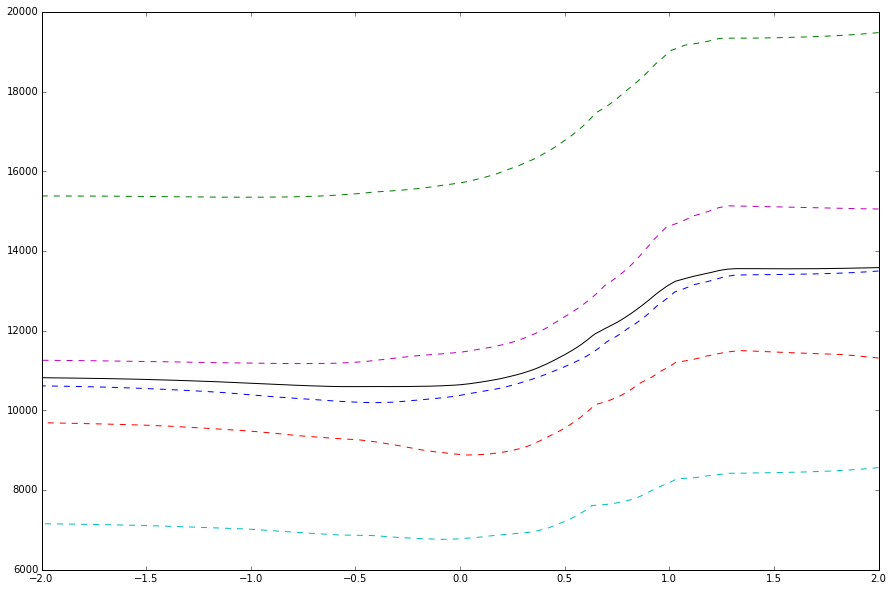

{'Minimum MSE': 10595.655356917619,
 'alpha': 0.30302710828663965,
 'intercept': 285.70078096586587,
 'r_square': 0.40892195207158999}

In [32]:
# the Model is auto selected by the LassoCV function
lasso_cros(alpha_range, trainPredictor, trainTarget[:,0], testPredictor, testTarget[:,0])

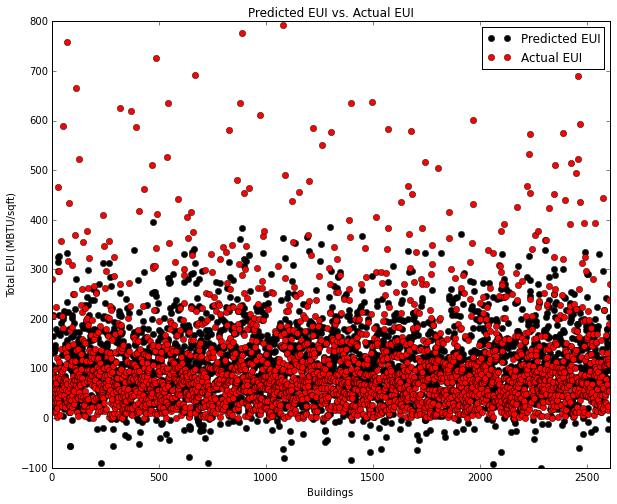

In [33]:
# the predicted value and real value are compared
testResults = lasso_results(0.30302710828663965, trainPredictor, trainTarget[:,0], testPredictor, testTarget[:,0])
fig2= plt.figure(figsize=(10, 8)) 
plt.plot(list(range(2608)), testResults, 'ko', label = 'Predicted EUI')
plt.plot(list(range(2608)), testTarget[:,0], 'ro', label = 'Actual EUI')
plt.ylim(-100, 800)
plt.xlim(0, len(testResults))
plt.xlabel("Buildings")
plt.ylabel("Total EUI (MBTU/sqft)")
plt.title("Predicted EUI vs. Actual EUI")
plt.legend()

The selected features are extracted

## Analyzing features

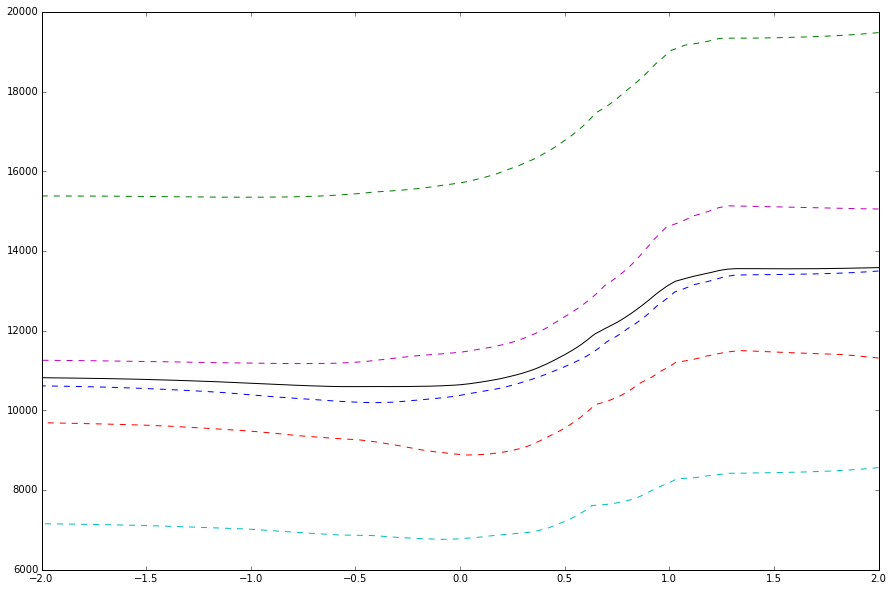

In [35]:
#Attributes selected
alpha = lasso_cros(alpha_range, trainPredictor, trainTarget[:,0], testPredictor, testTarget[:,0])["alpha"]
coefficient = lasso_fit(alpha, trainPredictor, trainTarget[:,0])
features = find_features(coefficient)["index"]

find the name of selected features

In [36]:
import csv

In [37]:
File = open('ALL_ATRIB_DATA_code.csv','r')
reader = csv.reader(File, delimiter = ',')
code = list(reader)
code = np.array(code)

The features selected is translated as shown below

In [41]:
code[features,1]

array(['Square footage', 'Square footage category',
       'Year of construction category', 'Principal building activity',
       'Electricity used', 'Natural gas used',
       'Fuel oil/diesel/kerosene used', 'Bottled gas/LPG/propane used',
       'District hot water used', 'Wall construction material ',
       'Roof construction material   ', 'Percent exterior glass     ',
       'Equal glass on all sides', 'Glass sides receive most sunlight',
       'Building shape ', 'Number of floors ', 'Elevators   ',
       'Number of elevators  ', 'Escalators ', 'Renovations since 1980  ',
       'Cosmetic improvements ', 'Exterior replacement',
       'Interior wall re-configuration', 'Plumbing system upgrade',
       'Insulation upgrade ', 'Government owned  ', 'Type of government',
       'Owner', 'Owner occupies space ', 'Number of businesses ',
       ' Number of businesses category ', 'Months in use past 12 months  ',
       'Space vacant 3 months in row', 'Open 24 hours a day  ',
       

In [38]:
#This function maps the feature to the file
def file_map(feature_index, code):
    basic = []
    file1 = []
    file2 = []
    file3 = []
    file4 = []
    file5 = []
    file6 = []
    file7 = []
    for i in feature_index:
        if code[i, 3] == "Basic info.":
            basic.append(code[i,1])
        elif code[i, 3] == "File (1)":
            file1.append(code[i, 1])
        elif code[i, 3] == "File (2)":
            file2.append(code[i, 1])
        elif code[i, 3] == "File (3)":
            file3.append(code[i, 1])
        elif code[i, 3] == "File (4)":
            file4.append(code[i, 1])
        elif code[i, 3] == "File (5)":
            file5.append(code[i, 1])
        elif code[i, 3] == "File (6)":
            file6.append(code[i, 1])
        elif code[i, 3] == "File (7)":
            file7.append(code[i, 1])
    print "The total number of features selected is \t{}.".format(len(feature_index))
    print "The number of features in Basic info is  \t{}.".format(len(basic))
    print "The number of features in File 1 is  \t{}.".format(len(file1))
    print "The number of features in File 2 is  \t{}.".format(len(file2))
    print "The number of features in File 3 is  \t{}.".format(len(file3))
    print "The number of features in File 4 is  \t{}.".format(len(file4))
    print "The number of features in File 5 is  \t{}.".format(len(file5))
    print "The number of features in File 6 is  \t{}.".format(len(file6))
    print "The number of features in File 7 is  \t{}.".format(len(file7))
    return None

We map the feature to the files

In [43]:
file_map(features, code)

The total number of features selected is 	114.
The number of features in Basic info is  	9.
The number of features in File 1 is  	33.
The number of features in File 2 is  	1.
The number of features in File 3 is  	20.
The number of features in File 4 is  	22.
The number of features in File 5 is  	11.
The number of features in File 6 is  	0.
The number of features in File 7 is  	16.


All the features are also mapped

In [44]:
file_map(list(range(159)), code)

The total number of features selected is 	159.
The number of features in Basic info is  	10.
The number of features in File 1 is  	46.
The number of features in File 2 is  	1.
The number of features in File 3 is  	31.
The number of features in File 4 is  	28.
The number of features in File 5 is  	20.
The number of features in File 6 is  	0.
The number of features in File 7 is  	21.


To improve the inpterpretability and understand what is the most important features, feature selection is performed

In [46]:
# this function returns the targeted number of features selected
def feature_reduc(alpha_input, train_X, train_y, threshold):
    feature_num = len(train_X[0])
    while feature_num > threshold:
        clf = linear_model.Lasso(alpha=alpha_input)
        clf.fit(train_X,train_y)
        feature_index = find_features(clf.coef_)["index"]
        feature_num = len(feature_index)
        alpha_input = alpha_input * 1.2      
    return {'alpha':alpha_input,  'feature_index': feature_index}

In [48]:
# Target 1 most important feature
code[feature_reduc(10, Predictor, Target[:,0],1)["feature_index"],1]

array(['Square footage'], 
      dtype='|S41')

In [50]:
# Target 3 most important feature
code[feature_reduc(10, Predictor, Target[:,0],3)["feature_index"],1]

array(['Square footage', 'Number of employees during main shift',
       'Heating degree days (base 65)'], 
      dtype='|S41')

In [51]:
# Target 5 most important feature
code[feature_reduc(10, Predictor, Target[:,0],5)["feature_index"],1]

array(['Square footage', 'Number of floors ',
       'Total weekly operating hours  ',
       'Number of employees during main shift',
       'Heating degree days (base 65)'], 
      dtype='|S41')

In [52]:
# Target 10 most important feature
code[feature_reduc(10, Predictor, Target[:,0],10)["feature_index"],1]

array(['Square footage', 'Number of floors ',
       'Total weekly operating hours  ',
       'Number of employees during main shift', 'Percent cooled  ',
       'Computer area percent', 'Number of computers  ',
       'Percent lit when open  ', 'Heating degree days (base 65)',
       'Cooling degree days (base 65)'], 
      dtype='|S41')

## Significance test 

In [61]:
# the MSE of the optimum model is used
MSE = 10595.655356917619
#alpha obtained from previous model
coef = coefficient = lasso_fit(0.30302710828663965, trainPredictor, trainTarget[:,0])
Y_pred=lasso_results(0.30372635797, trainPredictor, trainTarget[:,0], testPredictor, testTarget[:,0])
from scipy.stats import t
s2=MSE*np.linalg.inv(np.dot(np.transpose(testPredictor),testPredictor))
ss2=np.diag(s2)
ss=np.sqrt(ss2)
stu=t.isf((1-0.95)/2,2608-159)
Max=np.matrix(coef).T+np.matrix(stu*ss).T
Min=np.matrix(coef).T-np.matrix(stu*ss).T
beta_min_max=np.concatenate((Min,Max),axis=1)
print beta_min_max

[[ -3.49790201e-05   4.58736328e-05]
 [ -2.67595509e+01  -1.82561259e+01]
 [ -5.34256145e-02   5.77578848e+00]
 [ -3.70022832e-01   4.01745827e-01]
 [ -3.89405923e+01   7.90986366e+01]
 [ -6.37168084e+01  -2.26259583e+01]
 [ -3.06201657e+01   5.60879466e+00]
 [ -1.34614948e+01   2.19996186e+01]
 [ -5.74299981e+01   5.74299981e+01]
 [ -7.32112869e+01   3.71377510e+01]
 [ -7.14458563e+00   7.14458563e+00]
 [ -4.19645928e+02   4.19645928e+02]
 [ -6.57129830e+00  -1.00990745e+00]
 [ -3.45845344e+00   7.76644811e-01]
 [  4.69456951e-01   1.03734771e+01]
 [  1.45706350e+00   2.21307230e+01]
 [ -1.00089154e+01   6.53281507e+00]
 [ -3.38952830e+00  -9.95376966e-02]
 [ -7.32792997e-02  -2.12162382e-03]
 [ -1.23623872e+01   9.65906443e+00]
 [ -3.85229586e-01   3.40234412e+00]
 [ -7.80820530e+00   7.12254385e+01]
 [ -2.48504817e+01   1.52248683e+01]
 [ -1.80855574e+01   1.80855574e+01]
 [ -4.32948878e+01   4.32948878e+01]
 [ -1.59473575e+01   2.45343490e+01]
 [ -1.66782383e+01   1.86968231e+01]
 

T-test of the confidence interval at 99% is between -2.578 and 2.578
(1L, 25L)
[0, 18, 20, 38, 40, 45, 47, 58, 70, 79, 103, 104, 106, 110, 113, 136, 138, 147, 156, 157, 158]
(array([  1,   5,  12,  14,  15,  17,  18,  37,  38,  42,  45,  48,  64,
        75,  91,  94, 104, 112, 113, 126, 136, 139, 140, 157, 158], dtype=int64),)
[['Square footage category' 'Natural gas used'
  'Wall construction material ' 'Percent exterior glass     '
  'Equal glass on all sides' 'Building shape ' 'Number of floors '
  'Owner occupies space ' 'Number of businesses ' 'Open 24 hours a day  '
  'Total weekly operating hours  '
  'Number of employees main shift category'
  'District steam or hot water piped in ' 'District chilled water piped in'
  'Walk-in refrigeration units   ' 'Residential-type refrigerators '
  'Number of servers      ' 'Photocopiers ' 'Number of photocopiers '
  'Natural gas used for cooking' 'Percent lit when open  '
  'Lit when closed category   ' 'Lighting reduced during off hours'

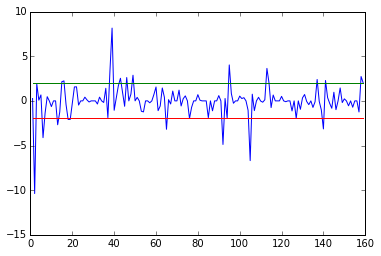

In [64]:
from scipy.stats import t
stu=t.isf((1-0.95)/2,2608-159)
T=coef/ss
print 'T-test of the confidence interval at 99% is between -2.578 and 2.578'
num=np.where((T<-stu)|(T>stu))
Stu_p=stu*np.ones(159)
x=np.linspace(1,159,num=159)
plt.plot(x,T,x,Stu_p,x,-Stu_p)
num_reject=np.matrix(num).shape
print num_reject
#print[code[num,1]]

print(numeric_index)
print(num)
print(code[num,1])